**Imports**

In [31]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from skimage.io import imread

# Set options for numpy to display numbers without scientific notation
np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

# Set global plotting configurations for better visualization
plt.rc('axes', titlesize=20)  # Font size of the Title
plt.rc('font', size=24)  # Font size for text
plt.rc('axes', labelsize=18)  # Font size for the x and y labels
plt.rc('xtick', labelsize=16)  # Font size of the x-axis tick labels
plt.rc('ytick', labelsize=16)  # Font size of the y-axis tick labels
plt.rc('legend', fontsize=14)  # Font size of the legend
plt.rc('figure', titlesize=24)  # Font size of the figure title

**Loading and Visualizing Image**

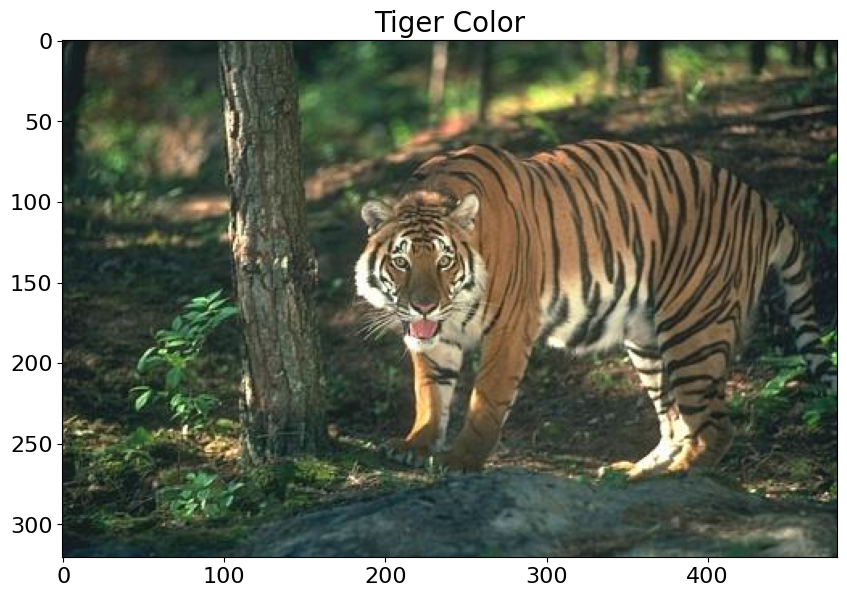

In [32]:
# Load the image from the dataset URL
image = imread("https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/108005.jpg")

# Display the image
fig = plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Tiger Color")
plt.axis("on")
plt.show()

**Generate Feature Vectors**

In [33]:
def generate_feature_vector(image):
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Obtain the row and column indices of the image (height and width)
    image_indices = np.indices((image_array.shape[0], image_array.shape[1]))

    # Initialize an array to store features: row index, column index, RGB
    # Handle grayscale images
    if image_array.ndim == 2:  # Grayscale image
        features = np.array([
            image_indices[0].flatten(),
            image_indices[1].flatten(),
            image_array.flatten()
        ]).T
    elif image_array.ndim == 3:  # RGB image
        features = np.array([
            image_indices[0].flatten(),
            image_indices[1].flatten(),
            image_array[..., 0].flatten(),
            image_array[..., 1].flatten(),
            image_array[..., 2].flatten()
        ]).T
    else:
        print("Incorrect image dimensions for feature extraction")
        return None, None

    # Normalize each feature to [0, 1]
    min_values = np.min(features, axis=0)
    max_values = np.max(features, axis=0)
    feature_ranges = max_values - min_values
    normalized_features = (features - min_values) / feature_ranges

    return image_array, normalized_features

**Fitting GMM and Predicting Labels**

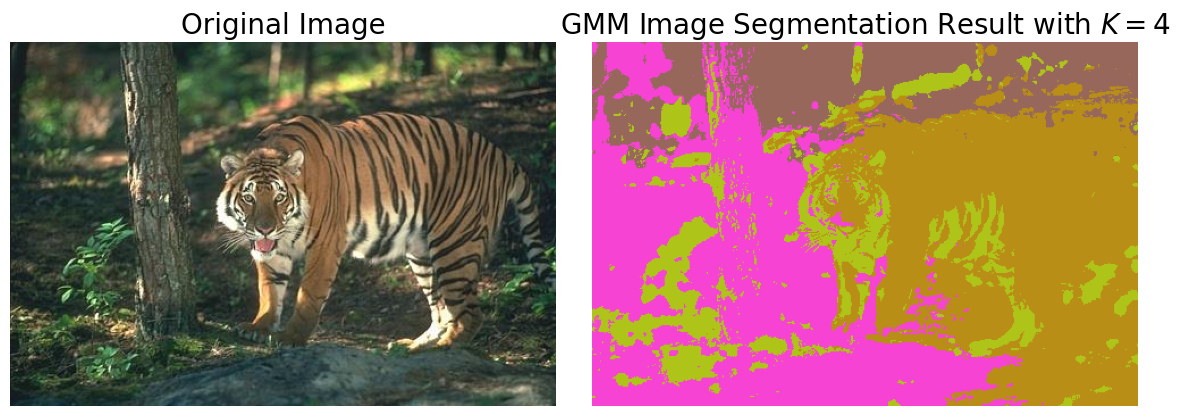

In [34]:
# Generate feature vectors for the image
img_np, feature_vector = generate_feature_vector(image)

# Fit GMM with predefined parameters
gmm = GaussianMixture(n_components=4, max_iter=400, tol=1e-3, random_state=42)
gmm.fit(feature_vector)

# Predict the most likely component labels for each pixel
gmm_predictions = gmm.predict(feature_vector)

# Reshape the labels to match the original image shape
labels_img = gmm_predictions.reshape(img_np.shape[0], img_np.shape[1])

# Generate a color map for the segmentation
# Assign a unique random color to each GMM component
n_components = gmm.n_components
colors = np.random.randint(0, 255, size=(n_components, 3))  # Random RGB values for each component

# Map labels to colors
segmentation_colored = np.zeros((img_np.shape[0], img_np.shape[1], 3), dtype=np.uint8)
for i in range(n_components):
    segmentation_colored[labels_img == i] = colors[i]

# Display the original and segmented images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Segmentation in color
axes[1].imshow(segmentation_colored)
axes[1].set_title(f"GMM Image Segmentation Result with $K = {n_components}$")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**Cross-Validation for GMM Components**

In [35]:
def k_fold_gmm_components(K, n_components_list, data):
    # Initialize space for storing validation log-likelihoods
    log_likelihood_valid = np.zeros((len(n_components_list), K))

    # Initialize K-Fold
    kf = KFold(n_splits=K, shuffle=True)

    # Iterate over model orders
    for m, comp in enumerate(n_components_list):
        for fold, (train_indices, val_indices) in enumerate(kf.split(data)):
            # Fit GMM on training data
            gmm = GaussianMixture(n_components=comp, max_iter=400, tol=1e-3)
            gmm.fit(data[train_indices])

            # Compute log-likelihood on validation data
            log_likelihood_valid[m, fold] = gmm.score(data[val_indices])

    # Compute average log-likelihood for each model order
    avg_log_likelihood = np.mean(log_likelihood_valid, axis=1)

    # Find the optimal number of components with the highest average log-likelihood
    best_component = n_components_list[np.argmax(avg_log_likelihood)]
    max_log_likelihood = np.max(avg_log_likelihood)

    # Display results
    print(f"Best No. Cluster Components: {best_component}")
    print(f"Log-Likelihood Score: {max_log_likelihood:.3f}")

    # Plotting the log-likelihood vs. number of components
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(n_components_list, avg_log_likelihood, marker="o")
    ax.set_title("No. Components vs Cross-Validation Log-Likelihood")
    ax.set_xlabel("$K$")
    ax.set_ylabel("Log-Likelihood")
    plt.show()

    return best_component

**Finding Best GMM Components**

Best No. Cluster Components: 20
Log-Likelihood Score: 5.191


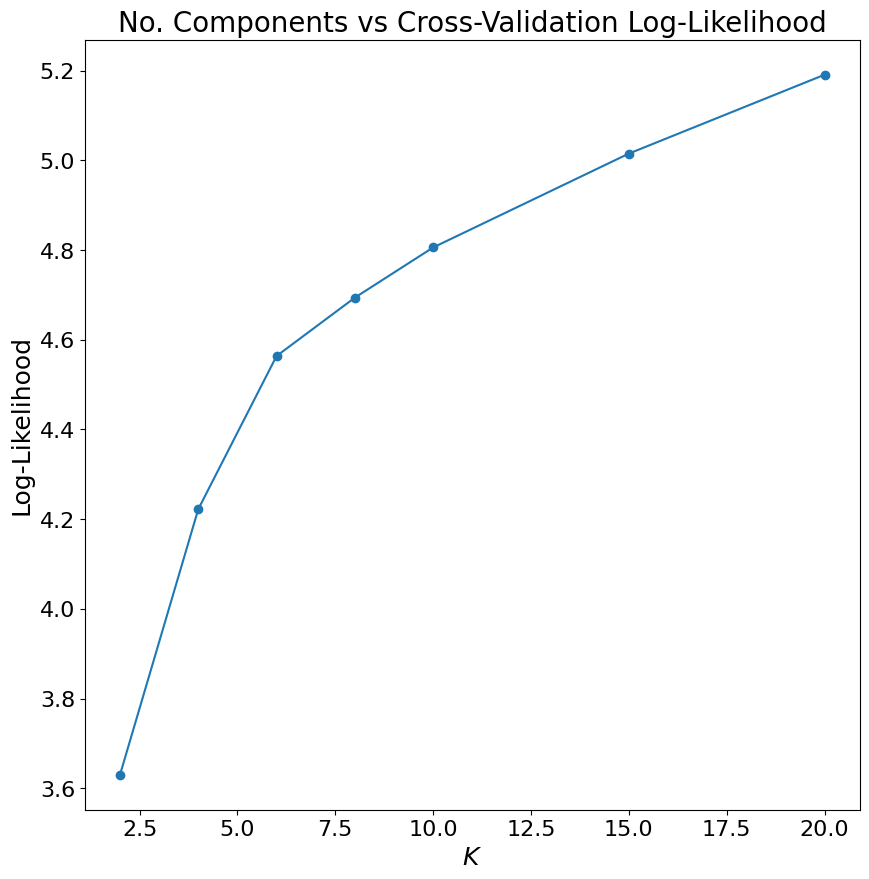

In [36]:
# Define parameters for cross-validation
k_folds = 10
n_components_list = [2, 4, 6, 8, 10, 15, 20]

# Perform cross-validation to find the best number of components
best_components = k_fold_gmm_components(k_folds, n_components_list, feature_vector)

In [37]:
def visualize_gmm_segmentation(image, feature_vector, best_components):
    # Create a 2x2 subplot to visualize the original image and three segmentations
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Display the original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    # Iterate over the best components and perform GMM segmentation
    for idx, n_components in enumerate(best_components):
        # Fit GMM with the specified number of components
        gmm = GaussianMixture(n_components=n_components, max_iter=400, tol=1e-3, random_state=42)
        gmm.fit(feature_vector)

        # Predict pixel labels
        gmm_predictions = gmm.predict(feature_vector)

        # Reshape the labels to match the original image dimensions
        labels_img = gmm_predictions.reshape(image.shape[0], image.shape[1])

        # Generate a random color mapping for the segmentation
        colors = np.random.randint(0, 255, size=(n_components, 3))
        segmentation_colored = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        for i in range(n_components):
            segmentation_colored[labels_img == i] = colors[i]

        # Determine subplot position
        row, col = divmod(idx + 1, 2)
        axes[row, col].imshow(segmentation_colored)
        axes[row, col].set_title(f"GMM Segmentation with $K = {n_components}$")
        axes[row, col].axis("off")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

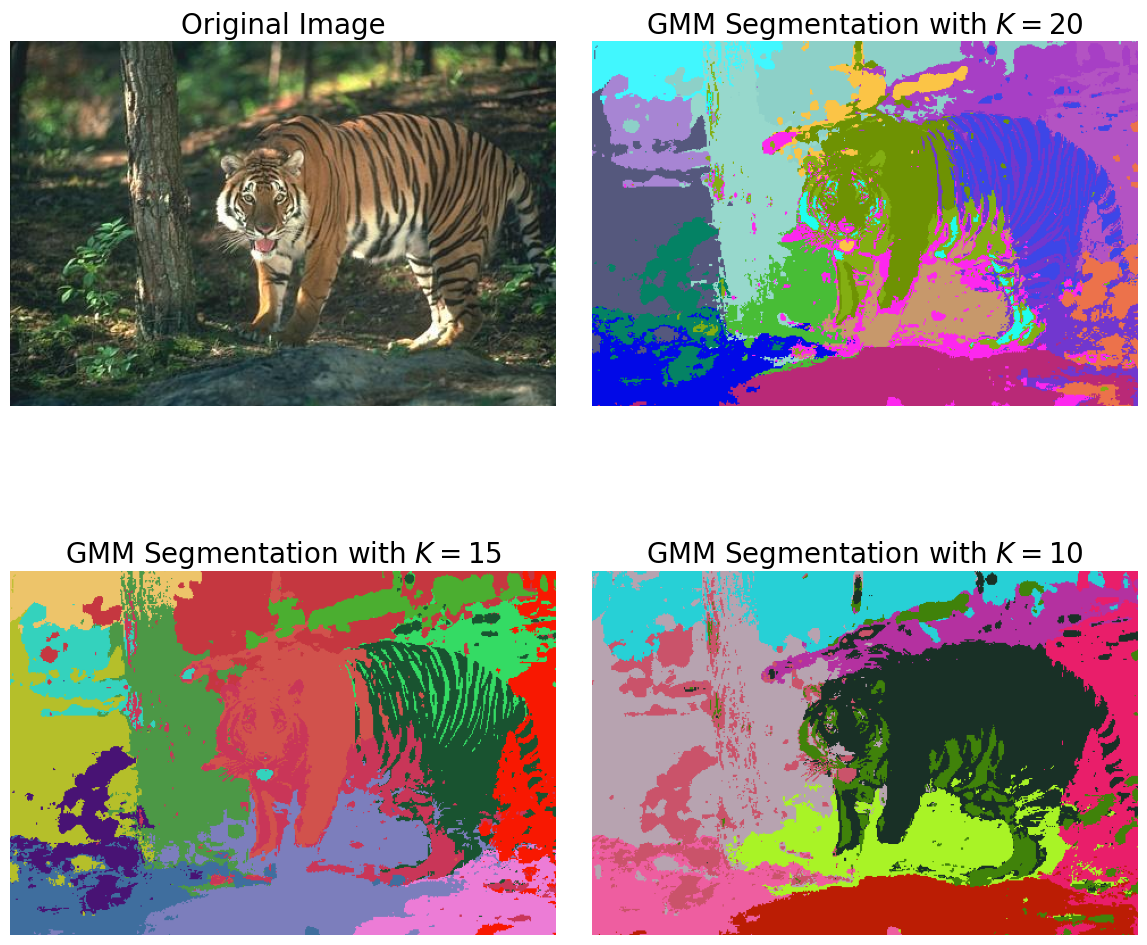

In [38]:
# Example usage with image, feature_vector, and best_components
best_components = [20, 15, 10]  # Replace with your top three GMM component counts
visualize_gmm_segmentation(image, feature_vector, best_components)